## Import Data and Library

In [2]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
 retail_data = pd.read_csv("/content/drive/MyDrive/DS Training/Meterial/uci_OnlineRetail.csv")

In [6]:
 retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [7]:
retail_data.shape

(541909, 8)

In [8]:
retail_data.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [9]:
retail_data.InvoiceDate = pd.to_datetime(retail_data.InvoiceDate)

In [10]:
retail_data["InvoiceDate_only"] = pd.to_datetime(retail_data.InvoiceDate).dt.date
retail_data["Invoice_year"] = pd.to_datetime(retail_data.InvoiceDate).dt.year
retail_data["Invoice_month"] = pd.to_datetime(retail_data.InvoiceDate).dt.month
retail_data["Invoice_quarter"] = pd.to_datetime(retail_data.InvoiceDate).dt.quarter
retail_data["Invoic_dayofweek"] = pd.to_datetime(retail_data.InvoiceDate).dt.dayofweek
retail_data['is_weekend'] = np.where(retail_data['Invoic_dayofweek'].isin(['Sunday','Saturday']),1,0)

retail_data["Invoice_year_month"] = retail_data["Invoice_year"].astype(str) + "_" + retail_data["Invoice_month"].astype(str)
retail_data["Invoice_year_quarter"] = retail_data["Invoice_year"].astype(str) + "_" + retail_data["Invoice_quarter"].astype(str)


In [11]:
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_only,Invoice_year,Invoice_month,Invoice_quarter,Invoic_dayofweek,is_weekend,Invoice_year_month,Invoice_year_quarter
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,2010-01-12,2010,1,1,1,0,2010_1,2010_1
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,2010-01-12,2010,1,1,1,0,2010_1,2010_1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,2010-01-12,2010,1,1,1,0,2010_1,2010_1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,2010-01-12,2010,1,1,1,0,2010_1,2010_1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,2010-01-12,2010,1,1,1,0,2010_1,2010_1


In [12]:
retail_data["Invoice_year_month"].unique()

array(['2010_1', '2010_2', '2010_3', '2010_5', '2010_6', '2010_7',
       '2010_8', '2010_9', '2010_10', '2010_12', '2011_4', '2011_5',
       '2011_6', '2011_7', '2011_9', '2011_10', '2011_11', '2011_12',
       '2011_1', '2011_2', '2011_3', '2011_8'], dtype=object)

## Derive Target Variable ( Dependent Variable)

### Define Parameters

In [13]:
import datetime
# Define Model Parameters for the the target variable

POO = datetime.date(2011, 10, 1)
days = 30
POO_minus_days = POO-datetime.timedelta(days=days)
POO_plus_days = POO+ datetime.timedelta(days=days+1)

In [14]:
POO_minus_days, POO, POO_plus_days

(datetime.date(2011, 9, 1),
 datetime.date(2011, 10, 1),
 datetime.date(2011, 11, 1))

### Derivation

In [15]:
customers_in_scope = retail_data[(retail_data["InvoiceDate_only"]>=POO_minus_days) & (retail_data["InvoiceDate_only"]<=POO)][["CustomerID","InvoiceDate_only"]]

In [16]:
type(customers_in_scope)

pandas.core.frame.DataFrame

In [17]:
# customers_in_scope= customers_in_scope.to_frame()
customers_in_scope.drop_duplicates(["CustomerID"],inplace=True)

In [18]:
customers_in_scope.shape

(1275, 2)

In [19]:
customers_in_scope.head()

,CustomerID,InvoiceDate_only
49034,17243.0,2011-09-01
49044,16923.0,2011-09-01
49068,15465.0,2011-09-01
49073,13162.0,2011-09-01
49110,13183.0,2011-09-01


In [20]:
target_1 = retail_data[(retail_data["InvoiceDate_only"]> POO) & (retail_data["InvoiceDate_only"]<=POO_plus_days)]["CustomerID"]

In [21]:
target_1= target_1.to_frame() 
target_1.drop_duplicates(inplace=True)

In [22]:
target_1.shape

(1361, 1)

In [23]:
target_1["target"] = 1

In [24]:
target_1.head()

,CustomerID,target
52127,12736.0,1
52131,17450.0,1
52135,13473.0,1
52191,14320.0,1
52214,NaN,1


In [25]:
customers_in_scope = customers_in_scope.merge(target_1,on = "CustomerID",how="left")

In [26]:
customers_in_scope.head()

,CustomerID,InvoiceDate_only,target
0,17243.0,2011-09-01,1.0
1,16923.0,2011-09-01,1.0
2,15465.0,2011-09-01,1.0
3,13162.0,2011-09-01,1.0
4,13183.0,2011-09-01,NaN


In [27]:
customers_in_scope["target"]= customers_in_scope["target"].fillna(0)

In [28]:
customers_in_scope

,CustomerID,InvoiceDate_only,target
0,17243.0,2011-09-01,1.0
1,16923.0,2011-09-01,1.0
2,15465.0,2011-09-01,1.0
3,13162.0,2011-09-01,1.0
4,13183.0,2011-09-01,0.0
...,...,...,...
1270,15910.0,2011-09-12,0.0
1271,17754.0,2011-09-12,0.0
1272,12662.0,2011-09-12,1.0
1273,12526.0,2011-09-12,1.0


In [29]:
customers_in_scope["target"].value_counts()

0.0    748
1.0    527
Name: target, dtype: int64

## Derive Independent Variables

In [30]:
Historical_days = 365  # 12 Months

### Select Historical data range of customer

In [31]:
# Get all transactions of customers that are part of model
customers_transaction = retail_data.merge(customers_in_scope, on='CustomerID',how="inner")  

In [32]:
customers_transaction.shape

(353474, 18)

In [33]:
customers_transaction.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_only_x,Invoice_year,Invoice_month,Invoice_quarter,Invoic_dayofweek,is_weekend,Invoice_year_month,Invoice_year_quarter,InvoiceDate_only_y,target
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-01-12 08:45:00,3.75,12583.0,France,2010-01-12,2010,1,1,1,0,2010_1,2010_1,2011-09-21,1.0
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-01-12 08:45:00,3.75,12583.0,France,2010-01-12,2010,1,1,1,0,2010_1,2010_1,2011-09-21,1.0
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-01-12 08:45:00,3.75,12583.0,France,2010-01-12,2010,1,1,1,0,2010_1,2010_1,2011-09-21,1.0


In [34]:
customers_transaction["POO"] = POO

In [35]:
customers_transaction["historical_months"] = (customers_transaction["InvoiceDate_only_y"] - customers_transaction["InvoiceDate_only_x"]).dt.days

In [36]:
customers_transaction_in_scope = customers_transaction[(customers_transaction["historical_months"]<=Historical_days) & (customers_transaction["historical_months"]>0)]

In [37]:
customers_transaction_in_scope.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_only_x,Invoice_year,Invoice_month,Invoice_quarter,Invoic_dayofweek,is_weekend,Invoice_year_month,Invoice_year_quarter,InvoiceDate_only_y,target,POO,historical_months
20,540455,21086,SET/6 RED SPOTTY PAPER CUPS,12,2011-07-01 12:07:00,0.65,12583.0,France,2011-07-01,2011,7,3,4,0,2011_7,2011_3,2011-09-21,1.0,2011-10-01,82
21,540455,21080,SET/20 RED RETROSPOT PAPER NAPKINS,12,2011-07-01 12:07:00,0.85,12583.0,France,2011-07-01,2011,7,3,4,0,2011_7,2011_3,2011-09-21,1.0,2011-10-01,82
22,540455,22726,ALARM CLOCK BAKELIKE GREEN,16,2011-07-01 12:07:00,3.75,12583.0,France,2011-07-01,2011,7,3,4,0,2011_7,2011_3,2011-09-21,1.0,2011-10-01,82
23,540455,22727,ALARM CLOCK BAKELIKE RED,12,2011-07-01 12:07:00,3.75,12583.0,France,2011-07-01,2011,7,3,4,0,2011_7,2011_3,2011-09-21,1.0,2011-10-01,82
24,540455,22728,ALARM CLOCK BAKELIKE PINK,12,2011-07-01 12:07:00,3.75,12583.0,France,2011-07-01,2011,7,3,4,0,2011_7,2011_3,2011-09-21,1.0,2011-10-01,82


In [38]:
customers_transaction_in_scope.describe()

,Quantity,UnitPrice,CustomerID,Invoice_year,Invoice_month,Invoice_quarter,Invoic_dayofweek,is_weekend,target,historical_months
count,220760.000000,220760.000000,124778.000000,220760.000000,220760.000000,220760.000000,220760.000000,220760.0,220760.000000,220760.000000
mean,9.249796,5.434193,15255.571824,2010.935047,5.362978,2.129824,2.675023,0.0,0.826400,141.195747
std,60.576397,96.406967,1713.488585,0.246443,2.898139,0.915560,1.912863,0.0,0.378766,82.905435
min,-9600.000000,0.000000,12347.000000,2010.000000,1.000000,1.000000,0.000000,0.0,0.000000,1.000000
25%,1.000000,1.250000,13985.000000,2011.000000,3.000000,1.000000,1.000000,0.0,1.000000,71.000000
50%,2.000000,2.460000,15039.000000,2011.000000,5.000000,2.000000,3.000000,0.0,1.000000,138.000000
75%,10.000000,4.150000,16764.000000,2011.000000,7.000000,3.000000,4.000000,0.0,1.000000,208.000000
max,5568.000000,17836.460000,18282.000000,2011.000000,12.000000,4.000000,6.000000,0.0,1.000000,365.000000


## Derive Features

In [39]:
train = customers_in_scope

In [40]:
train.drop("InvoiceDate_only", inplace=True, axis=1)

In [41]:
train.head()

,CustomerID,target
0,17243.0,1.0
1,16923.0,1.0
2,15465.0,1.0
3,13162.0,1.0
4,13183.0,0.0


In [42]:
transactions_count = customers_transaction_in_scope.groupby("CustomerID").agg({'InvoiceNo': ['count']}).reset_index()
transactions_values = customers_transaction_in_scope.groupby("CustomerID").agg({'UnitPrice': ['mean', 'min', 'max']}).reset_index()
transactions_count.head()

,CustomerID,InvoiceNo
,,count
0,12347.0,86
1,12348.0,28
2,12352.0,63
3,12362.0,126
4,12364.0,61


In [43]:
transactions_count.columns = transactions_count.columns.map('_'.join)
transactions_count = transactions_count.rename(columns={"CustomerID_":"CustomerID"})

In [44]:
transactions_count.head()

,CustomerID,InvoiceNo_count
0,12347.0,86
1,12348.0,28
2,12352.0,63
3,12362.0,126
4,12364.0,61


In [45]:
transactions_values.head()

CustomerID  UnitPrice              
                   mean   min     max
0    12347.0   2.526047  0.25   12.75
1    12348.0   4.864643  0.29   40.00
2    12352.0  31.533333  0.65  376.50
3    12362.0   3.322460  0.21   18.00
4    12364.0   1.699672  0.42   15.00

In [46]:
transactions_values.columns = transactions_values.columns.map('_'.join)
transactions_values = transactions_values.rename(columns={"CustomerID_":"CustomerID"})

In [47]:
transactions_values.head()

,CustomerID,UnitPrice_mean,UnitPrice_min,UnitPrice_max
0,12347.0,2.526047,0.25,12.75
1,12348.0,4.864643,0.29,40.00
2,12352.0,31.533333,0.65,376.50
3,12362.0,3.322460,0.21,18.00
4,12364.0,1.699672,0.42,15.00


In [48]:
train = train.merge(transactions_count,on="CustomerID").merge(transactions_values,on="CustomerID")
train.head()

,CustomerID,target,InvoiceNo_count,UnitPrice_mean,UnitPrice_min,UnitPrice_max
0,17243.0,1.0,267,4.439476,0.12,12.75
1,16923.0,1.0,443,3.102054,0.29,12.75
2,15465.0,1.0,60,7.391167,1.25,14.95
3,13162.0,1.0,23,1.835652,0.19,5.45
4,13183.0,0.0,66,2.133636,0.30,8.50


In [49]:
train = train.astype(int)

In [50]:
train.dtypes

CustomerID         int64
target             int64
InvoiceNo_count    int64
UnitPrice_mean     int64
UnitPrice_min      int64
UnitPrice_max      int64
dtype: object

In [51]:
X =train.drop(columns=["target"])
y =train["target"]

In [52]:
#train.drop(columns=['target'], axis =1,inplace= True, errors='ignore')

In [53]:
train.head()

,CustomerID,target,InvoiceNo_count,UnitPrice_mean,UnitPrice_min,UnitPrice_max
0,17243,1,267,4,0,12
1,16923,1,443,3,0,12
2,15465,1,60,7,1,14
3,13162,1,23,1,0,5
4,13183,0,66,2,0,8


In [54]:
retail_cat=retail_data[['CustomerID','Country']]


In [55]:
retail_cat = pd.get_dummies(retail_cat)

In [56]:
retail_cat_agg = retail_cat.groupby("CustomerID").agg([np.sum]).reset_index()

In [57]:
retail_cat_agg.head()

,CustomerID,Country_Australia,Country_Austria,Country_Bahrain,Country_Belgium,Country_Brazil,Country_Canada,Country_Channel Islands,Country_Cyprus,Country_Czech Republic,Country_Denmark,Country_EIRE,Country_European Community,Country_Finland,Country_France,Country_Germany,Country_Greece,Country_Hong Kong,Country_Iceland,Country_Israel,Country_Italy,Country_Japan,Country_Lebanon,Country_Lithuania,Country_Malta,Country_Netherlands,Country_Norway,Country_Poland,Country_Portugal,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
,,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum
0,12346.0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0.0,0,0.0,0,0,2.0,0
1,12347.0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0,0,182,0,0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0.0,0,0.0,0,0,0.0,0
2,12348.0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,31.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0.0,0,0.0,0,0,0.0,0
3,12349.0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0,0,0,0,73,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0.0,0,0.0,0,0,0.0,0
4,12350.0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,17.0,0,0.0,0,0,0,0.0,0,0.0,0,0,0.0,0


In [58]:
retail_cat_agg.columns.map("_".join)

Index(['CustomerID_', 'Country_Australia_sum', 'Country_Austria_sum',
       'Country_Bahrain_sum', 'Country_Belgium_sum', 'Country_Brazil_sum',
       'Country_Canada_sum', 'Country_Channel Islands_sum',
       'Country_Cyprus_sum', 'Country_Czech Republic_sum',
       'Country_Denmark_sum', 'Country_EIRE_sum',
       'Country_European Community_sum', 'Country_Finland_sum',
       'Country_France_sum', 'Country_Germany_sum', 'Country_Greece_sum',
       'Country_Hong Kong_sum', 'Country_Iceland_sum', 'Country_Israel_sum',
       'Country_Italy_sum', 'Country_Japan_sum', 'Country_Lebanon_sum',
       'Country_Lithuania_sum', 'Country_Malta_sum', 'Country_Netherlands_sum',
       'Country_Norway_sum', 'Country_Poland_sum', 'Country_Portugal_sum',
       'Country_RSA_sum', 'Country_Saudi Arabia_sum', 'Country_Singapore_sum',
       'Country_Spain_sum', 'Country_Sweden_sum', 'Country_Switzerland_sum',
       'Country_USA_sum', 'Country_United Arab Emirates_sum',
       'Country_United Kin

In [59]:
retail_cat_agg.columns = retail_cat_agg.columns.map('_'.join)
retail_cat_agg = retail_cat_agg.rename(columns={"CustomerID_":"CustomerID"})

In [60]:
retail_cat_agg.head()

,CustomerID,Country_Australia_sum,Country_Austria_sum,Country_Bahrain_sum,Country_Belgium_sum,Country_Brazil_sum,Country_Canada_sum,Country_Channel Islands_sum,Country_Cyprus_sum,Country_Czech Republic_sum,Country_Denmark_sum,Country_EIRE_sum,Country_European Community_sum,Country_Finland_sum,Country_France_sum,Country_Germany_sum,Country_Greece_sum,Country_Hong Kong_sum,Country_Iceland_sum,Country_Israel_sum,Country_Italy_sum,Country_Japan_sum,Country_Lebanon_sum,Country_Lithuania_sum,Country_Malta_sum,Country_Netherlands_sum,Country_Norway_sum,Country_Poland_sum,Country_Portugal_sum,Country_RSA_sum,Country_Saudi Arabia_sum,Country_Singapore_sum,Country_Spain_sum,Country_Sweden_sum,Country_Switzerland_sum,Country_USA_sum,Country_United Arab Emirates_sum,Country_United Kingdom_sum,Country_Unspecified_sum
0,12346.0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0.0,0,0.0,0,0,2.0,0
1,12347.0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0,0,182,0,0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0.0,0,0.0,0,0,0.0,0
2,12348.0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,31.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0.0,0,0.0,0,0,0.0,0
3,12349.0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0,0,0,0,73,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0.0,0,0.0,0,0,0.0,0
4,12350.0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,17.0,0,0.0,0,0,0,0.0,0,0.0,0,0,0.0,0


In [61]:
retail_data.dtypes

InvoiceNo                       object
StockCode                       object
Description                     object
Quantity                         int64
InvoiceDate             datetime64[ns]
UnitPrice                      float64
CustomerID                     float64
Country                         object
InvoiceDate_only                object
Invoice_year                     int64
Invoice_month                    int64
Invoice_quarter                  int64
Invoic_dayofweek                 int64
is_weekend                       int64
Invoice_year_month              object
Invoice_year_quarter            object
dtype: object

In [62]:
retail_num=retail_data[['Quantity','UnitPrice','CustomerID']]

In [63]:
retail_num_agg = retail_num.groupby("CustomerID").agg([np.sum,np.mean,np.max,np.min,np.median]).reset_index()

In [64]:
retail_num_agg.head()

CustomerID Quantity                    ... UnitPrice                     
                  sum       mean   amax  ...      mean    amax  amin median
0    12346.0        0   0.000000  74215  ...  1.040000    1.04  1.04  1.040
1    12347.0     2458  13.505495    240  ...  2.644011   12.75  0.25  2.015
2    12348.0     2341  75.516129    144  ...  5.764839   40.00  0.29  0.550
3    12349.0      631   8.643836     36  ...  8.289041  300.00  0.42  2.550
4    12350.0      197  11.588235     24  ...  3.841176   40.00  0.85  1.650

[5 rows x 11 columns]

In [65]:
retail_num_agg.columns = retail_num_agg.columns.map('_'.join)
retail_num_agg = retail_num_agg.rename(columns={"CustomerID_":"CustomerID"})

In [66]:
retail_num_agg.head(5)

,CustomerID,Quantity_sum,Quantity_mean,Quantity_amax,Quantity_amin,Quantity_median,UnitPrice_sum,UnitPrice_mean,UnitPrice_amax,UnitPrice_amin,UnitPrice_median
0,12346.0,0,0.000000,74215,-74215,0.0,2.08,1.040000,1.04,1.04,1.040
1,12347.0,2458,13.505495,240,2,12.0,481.21,2.644011,12.75,0.25,2.015
2,12348.0,2341,75.516129,144,1,72.0,178.71,5.764839,40.00,0.29,0.550
3,12349.0,631,8.643836,36,1,6.0,605.10,8.289041,300.00,0.42,2.550
4,12350.0,197,11.588235,24,1,12.0,65.30,3.841176,40.00,0.85,1.650


In [67]:
retail_data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'InvoiceDate_only',
       'Invoice_year', 'Invoice_month', 'Invoice_quarter', 'Invoic_dayofweek',
       'is_weekend', 'Invoice_year_month', 'Invoice_year_quarter'],
      dtype='object')

In [68]:
retail_date=retail_data[["CustomerID",'InvoiceDate','InvoiceDate_only','Invoice_year','Invoice_month','Invoice_quarter', 'Invoic_dayofweek',
       'is_weekend', 'Invoice_year_month', 'Invoice_year_quarter']]

In [69]:
retail_date.head(5)

,CustomerID,InvoiceDate,InvoiceDate_only,Invoice_year,Invoice_month,Invoice_quarter,Invoic_dayofweek,is_weekend,Invoice_year_month,Invoice_year_quarter
0,17850.0,2010-01-12 08:26:00,2010-01-12,2010,1,1,1,0,2010_1,2010_1
1,17850.0,2010-01-12 08:26:00,2010-01-12,2010,1,1,1,0,2010_1,2010_1
2,17850.0,2010-01-12 08:26:00,2010-01-12,2010,1,1,1,0,2010_1,2010_1
3,17850.0,2010-01-12 08:26:00,2010-01-12,2010,1,1,1,0,2010_1,2010_1
4,17850.0,2010-01-12 08:26:00,2010-01-12,2010,1,1,1,0,2010_1,2010_1


In [70]:
retail_date.dtypes

CustomerID                     float64
InvoiceDate             datetime64[ns]
InvoiceDate_only                object
Invoice_year                     int64
Invoice_month                    int64
Invoice_quarter                  int64
Invoic_dayofweek                 int64
is_weekend                       int64
Invoice_year_month              object
Invoice_year_quarter            object
dtype: object

In [71]:
dummy_cols = ['Invoice_year','Invoice_month','Invoice_quarter', 'Invoic_dayofweek',
       'is_weekend', 'Invoice_year_month', 'Invoice_year_quarter']
       
retail_date_dum = pd.get_dummies(retail_date,columns=dummy_cols).astype(object)

In [72]:
retail_date_agg = retail_date_dum.drop(["InvoiceDate","InvoiceDate_only"],axis =1 ).groupby("CustomerID").agg([np.sum]).reset_index()

In [73]:
retail_date_agg.head()

,CustomerID,Invoice_year_2010,Invoice_year_2011,Invoice_month_1,Invoice_month_2,Invoice_month_3,Invoice_month_4,Invoice_month_5,Invoice_month_6,Invoice_month_7,Invoice_month_8,Invoice_month_9,Invoice_month_10,Invoice_month_11,Invoice_month_12,Invoice_quarter_1,Invoice_quarter_2,Invoice_quarter_3,Invoice_quarter_4,Invoic_dayofweek_0,Invoic_dayofweek_1,Invoic_dayofweek_2,Invoic_dayofweek_3,Invoic_dayofweek_4,Invoic_dayofweek_5,Invoic_dayofweek_6,is_weekend_0,Invoice_year_month_2010_1,Invoice_year_month_2010_10,Invoice_year_month_2010_12,Invoice_year_month_2010_2,Invoice_year_month_2010_3,Invoice_year_month_2010_5,Invoice_year_month_2010_6,Invoice_year_month_2010_7,Invoice_year_month_2010_8,Invoice_year_month_2010_9,Invoice_year_month_2011_1,Invoice_year_month_2011_10,Invoice_year_month_2011_11,Invoice_year_month_2011_12,Invoice_year_month_2011_2,Invoice_year_month_2011_3,Invoice_year_month_2011_4,Invoice_year_month_2011_5,Invoice_year_month_2011_6,Invoice_year_month_2011_7,Invoice_year_month_2011_8,Invoice_year_month_2011_9,Invoice_year_quarter_2010_1,Invoice_year_quarter_2010_2,Invoice_year_quarter_2010_3,Invoice_year_quarter_2010_4,Invoice_year_quarter_2011_1,Invoice_year_quarter_2011_2,Invoice_year_quarter_2011_3,Invoice_year_quarter_2011_4
,,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum
0,12346.0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0
1,12347.0,31,151,29,22,0,0,0,0,66,0,18,47,0,0,51,0,84,47,102,51,29,0,0,0,0,182,0,0,0,0,0,0,0,31,0,0,29,47,0,0,22,0,0,0,0,35,0,18,0,0,31,0,51,0,53,47
2,12348.0,17,14,6,0,0,0,5,0,0,0,3,0,0,17,6,5,3,17,0,6,5,17,0,0,3,31,0,0,17,0,0,0,0,0,0,0,6,0,0,0,0,0,0,5,0,0,0,3,0,0,0,17,6,5,3,0
3,12349.0,0,73,0,0,0,0,0,0,0,0,0,0,73,0,0,0,0,73,73,0,0,0,0,0,0,73,0,0,0,0,0,0,0,0,0,0,0,0,73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,73
4,12350.0,0,17,0,17,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,17,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0


In [74]:
retail_date_agg.columns = retail_date_agg.columns.map('_'.join)
retail_date_agg = retail_date_agg.rename(columns={"CustomerID_":"CustomerID"})

In [75]:
retail_date_agg.head()

,CustomerID,Invoice_year_2010_sum,Invoice_year_2011_sum,Invoice_month_1_sum,Invoice_month_2_sum,Invoice_month_3_sum,Invoice_month_4_sum,Invoice_month_5_sum,Invoice_month_6_sum,Invoice_month_7_sum,Invoice_month_8_sum,Invoice_month_9_sum,Invoice_month_10_sum,Invoice_month_11_sum,Invoice_month_12_sum,Invoice_quarter_1_sum,Invoice_quarter_2_sum,Invoice_quarter_3_sum,Invoice_quarter_4_sum,Invoic_dayofweek_0_sum,Invoic_dayofweek_1_sum,Invoic_dayofweek_2_sum,Invoic_dayofweek_3_sum,Invoic_dayofweek_4_sum,Invoic_dayofweek_5_sum,Invoic_dayofweek_6_sum,is_weekend_0_sum,Invoice_year_month_2010_1_sum,Invoice_year_month_2010_10_sum,Invoice_year_month_2010_12_sum,Invoice_year_month_2010_2_sum,Invoice_year_month_2010_3_sum,Invoice_year_month_2010_5_sum,Invoice_year_month_2010_6_sum,Invoice_year_month_2010_7_sum,Invoice_year_month_2010_8_sum,Invoice_year_month_2010_9_sum,Invoice_year_month_2011_1_sum,Invoice_year_month_2011_10_sum,Invoice_year_month_2011_11_sum,Invoice_year_month_2011_12_sum,Invoice_year_month_2011_2_sum,Invoice_year_month_2011_3_sum,Invoice_year_month_2011_4_sum,Invoice_year_month_2011_5_sum,Invoice_year_month_2011_6_sum,Invoice_year_month_2011_7_sum,Invoice_year_month_2011_8_sum,Invoice_year_month_2011_9_sum,Invoice_year_quarter_2010_1_sum,Invoice_year_quarter_2010_2_sum,Invoice_year_quarter_2010_3_sum,Invoice_year_quarter_2010_4_sum,Invoice_year_quarter_2011_1_sum,Invoice_year_quarter_2011_2_sum,Invoice_year_quarter_2011_3_sum,Invoice_year_quarter_2011_4_sum
0,12346.0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0
1,12347.0,31,151,29,22,0,0,0,0,66,0,18,47,0,0,51,0,84,47,102,51,29,0,0,0,0,182,0,0,0,0,0,0,0,31,0,0,29,47,0,0,22,0,0,0,0,35,0,18,0,0,31,0,51,0,53,47
2,12348.0,17,14,6,0,0,0,5,0,0,0,3,0,0,17,6,5,3,17,0,6,5,17,0,0,3,31,0,0,17,0,0,0,0,0,0,0,6,0,0,0,0,0,0,5,0,0,0,3,0,0,0,17,6,5,3,0
3,12349.0,0,73,0,0,0,0,0,0,0,0,0,0,73,0,0,0,0,73,73,0,0,0,0,0,0,73,0,0,0,0,0,0,0,0,0,0,0,0,73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,73
4,12350.0,0,17,0,17,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,17,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0


In [76]:
retail_stock=retail_data[['CustomerID','StockCode']]

In [77]:
retail_stock.head()

,CustomerID,StockCode
0,17850.0,85123A
1,17850.0,71053
2,17850.0,84406B
3,17850.0,84029G
4,17850.0,84029E


In [78]:
retail_stock = pd.get_dummies(retail_stock)
retail_stock.head()

,CustomerID,StockCode_10002,StockCode_10080,StockCode_10120,StockCode_10123C,StockCode_10123G,StockCode_10124A,StockCode_10124G,StockCode_10125,StockCode_10133,StockCode_10134,StockCode_10135,StockCode_11001,StockCode_15030,StockCode_15034,StockCode_15036,StockCode_15039,StockCode_15044A,StockCode_15044B,StockCode_15044C,StockCode_15044D,StockCode_15056BL,StockCode_15056N,StockCode_15056P,StockCode_15056bl,StockCode_15056n,StockCode_15056p,StockCode_15058A,StockCode_15058B,StockCode_15058C,StockCode_15060B,StockCode_15060b,StockCode_16008,StockCode_16010,StockCode_16011,StockCode_16012,StockCode_16014,StockCode_16015,StockCode_16016,StockCode_16020C,...,StockCode_90214S,StockCode_90214T,StockCode_90214U,StockCode_90214V,StockCode_90214W,StockCode_90214Y,StockCode_90214Z,StockCode_AMAZONFEE,StockCode_B,StockCode_BANK CHARGES,StockCode_C2,StockCode_CRUK,StockCode_D,StockCode_DCGS0003,StockCode_DCGS0004,StockCode_DCGS0055,StockCode_DCGS0057,StockCode_DCGS0066P,StockCode_DCGS0067,StockCode_DCGS0068,StockCode_DCGS0069,StockCode_DCGS0070,StockCode_DCGS0071,StockCode_DCGS0072,StockCode_DCGS0073,StockCode_DCGS0074,StockCode_DCGS0076,StockCode_DCGSSBOY,StockCode_DCGSSGIRL,StockCode_DOT,StockCode_M,StockCode_PADS,StockCode_POST,StockCode_S,StockCode_gift_0001_10,StockCode_gift_0001_20,StockCode_gift_0001_30,StockCode_gift_0001_40,StockCode_gift_0001_50,StockCode_m
0,17850.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,17850.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,17850.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,17850.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,17850.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [79]:
retail_stock = retail_stock.groupby("CustomerID").agg([np.sum]).reset_index()

In [80]:
retail_stock.columns = retail_stock.columns.map('_'.join)
retail_stock = retail_stock.rename(columns={"CustomerID_":"CustomerID"})

In [81]:
retail_stock.head(100)

,CustomerID,StockCode_10002_sum,StockCode_10080_sum,StockCode_10120_sum,StockCode_10123C_sum,StockCode_10123G_sum,StockCode_10124A_sum,StockCode_10124G_sum,StockCode_10125_sum,StockCode_10133_sum,StockCode_10134_sum,StockCode_10135_sum,StockCode_11001_sum,StockCode_15030_sum,StockCode_15034_sum,StockCode_15036_sum,StockCode_15039_sum,StockCode_15044A_sum,StockCode_15044B_sum,StockCode_15044C_sum,StockCode_15044D_sum,StockCode_15056BL_sum,StockCode_15056N_sum,StockCode_15056P_sum,StockCode_15056bl_sum,StockCode_15056n_sum,StockCode_15056p_sum,StockCode_15058A_sum,StockCode_15058B_sum,StockCode_15058C_sum,StockCode_15060B_sum,StockCode_15060b_sum,StockCode_16008_sum,StockCode_16010_sum,StockCode_16011_sum,StockCode_16012_sum,StockCode_16014_sum,StockCode_16015_sum,StockCode_16016_sum,StockCode_16020C_sum,...,StockCode_90214S_sum,StockCode_90214T_sum,StockCode_90214U_sum,StockCode_90214V_sum,StockCode_90214W_sum,StockCode_90214Y_sum,StockCode_90214Z_sum,StockCode_AMAZONFEE_sum,StockCode_B_sum,StockCode_BANK CHARGES_sum,StockCode_C2_sum,StockCode_CRUK_sum,StockCode_D_sum,StockCode_DCGS0003_sum,StockCode_DCGS0004_sum,StockCode_DCGS0055_sum,StockCode_DCGS0057_sum,StockCode_DCGS0066P_sum,StockCode_DCGS0067_sum,StockCode_DCGS0068_sum,StockCode_DCGS0069_sum,StockCode_DCGS0070_sum,StockCode_DCGS0071_sum,StockCode_DCGS0072_sum,StockCode_DCGS0073_sum,StockCode_DCGS0074_sum,StockCode_DCGS0076_sum,StockCode_DCGSSBOY_sum,StockCode_DCGSSGIRL_sum,StockCode_DOT_sum,StockCode_M_sum,StockCode_PADS_sum,StockCode_POST_sum,StockCode_S_sum,StockCode_gift_0001_10_sum,StockCode_gift_0001_20_sum,StockCode_gift_0001_30_sum,StockCode_gift_0001_40_sum,StockCode_gift_0001_50_sum,StockCode_m_sum
0,12346.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,12347.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12348.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0
3,12349.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,12350.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,12462.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0
96,12463.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0
97,12464.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0
98,12465.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0


In [82]:
# Aggrigate all dataframes here
all_agg_data = train.merge(transactions_count,on="CustomerID"). \
            merge(retail_num_agg,on="CustomerID").\
            merge(retail_cat_agg,on="CustomerID").\
            merge(retail_date_agg,on="CustomerID").\
            merge(retail_stock,on="CustomerID")


In [83]:
all_agg_data.head()

,CustomerID,target,InvoiceNo_count_x,UnitPrice_mean_x,UnitPrice_min,UnitPrice_max,InvoiceNo_count_y,Quantity_sum,Quantity_mean,Quantity_amax,Quantity_amin,Quantity_median,UnitPrice_sum,UnitPrice_mean_y,UnitPrice_amax,UnitPrice_amin,UnitPrice_median,Country_Australia_sum,Country_Austria_sum,Country_Bahrain_sum,Country_Belgium_sum,Country_Brazil_sum,Country_Canada_sum,Country_Channel Islands_sum,Country_Cyprus_sum,Country_Czech Republic_sum,Country_Denmark_sum,Country_EIRE_sum,Country_European Community_sum,Country_Finland_sum,Country_France_sum,Country_Germany_sum,Country_Greece_sum,Country_Hong Kong_sum,Country_Iceland_sum,Country_Israel_sum,Country_Italy_sum,Country_Japan_sum,Country_Lebanon_sum,Country_Lithuania_sum,...,StockCode_90214S_sum,StockCode_90214T_sum,StockCode_90214U_sum,StockCode_90214V_sum,StockCode_90214W_sum,StockCode_90214Y_sum,StockCode_90214Z_sum,StockCode_AMAZONFEE_sum,StockCode_B_sum,StockCode_BANK CHARGES_sum,StockCode_C2_sum,StockCode_CRUK_sum,StockCode_D_sum,StockCode_DCGS0003_sum,StockCode_DCGS0004_sum,StockCode_DCGS0055_sum,StockCode_DCGS0057_sum,StockCode_DCGS0066P_sum,StockCode_DCGS0067_sum,StockCode_DCGS0068_sum,StockCode_DCGS0069_sum,StockCode_DCGS0070_sum,StockCode_DCGS0071_sum,StockCode_DCGS0072_sum,StockCode_DCGS0073_sum,StockCode_DCGS0074_sum,StockCode_DCGS0076_sum,StockCode_DCGSSBOY_sum,StockCode_DCGSSGIRL_sum,StockCode_DOT_sum,StockCode_M_sum,StockCode_PADS_sum,StockCode_POST_sum,StockCode_S_sum,StockCode_gift_0001_10_sum,StockCode_gift_0001_20_sum,StockCode_gift_0001_30_sum,StockCode_gift_0001_40_sum,StockCode_gift_0001_50_sum,StockCode_m_sum
0,17243,1,267,4,0,12,267,3362,8.260442,96,-2,5.0,1722.56,4.232334,16.65,0.12,3.75,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,16923,1,443,3,0,12,443,3183,4.573276,192,-40,3.0,2161.05,3.104957,12.75,0.12,2.10,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,15465,1,60,7,1,14,60,1217,11.701923,120,-9,5.0,720.23,6.925288,14.95,1.25,6.75,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,13162,1,23,1,0,5,23,1663,20.280488,54,-24,22.0,118.50,1.445122,9.95,0.19,0.85,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,13183,0,66,2,0,8,66,2208,23.489362,96,1,12.0,191.07,2.032660,8.50,0.30,1.69,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [84]:
all_agg_data.shape

(1022, 4181)

In [85]:
X =all_agg_data.drop(columns=["target","CustomerID"])
y =all_agg_data["target"]

## Split Train and Test

In [86]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [87]:
clf = RandomForestClassifier(n_estimators=1000,max_depth=4, random_state=0)
clf.fit(X_train, y_train) # Train Model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [88]:
clf.feature_importances_

array([0.01209322, 0.00067734, 0.00010544, ..., 0.        , 0.        ,
       0.        ])

In [89]:
test_prob = clf.predict_proba(X_test)

In [90]:
test_prob=pd.DataFrame(test_prob).loc[:,1]

In [91]:
test_prob # Predicted values

0      0.510398
1      0.317472
2      0.482290
3      0.682318
4      0.540545
         ...   
302    0.498873
303    0.729222
304    0.340405
305    0.566211
306    0.278045
Name: 1, Length: 307, dtype: float64

In [92]:
y_test.head() # Actual Values

992    1
478    0
689    0
31     1
617    1
Name: target, dtype: int64

In [127]:
y_test = pd.DataFrame(y_test)

In [94]:
y_test= y_test.reset_index()

In [95]:
y_test["test_prob"] = test_prob

In [96]:
y_test.head()

,index,target,test_prob
0,992,1,0.510398
1,478,0,0.317472
2,689,0,0.482290
3,31,1,0.682318
4,617,1,0.540545


In [97]:
y_test["pred_class"] = np.where(y_test.test_prob>0.5,1,0)

In [98]:
y_test.head()

,index,target,test_prob,pred_class
0,992,1,0.510398,1
1,478,0,0.317472,0
2,689,0,0.482290,0
3,31,1,0.682318,1
4,617,1,0.540545,1


In [99]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test.target, y_test.pred_class)

array([[155,  10],
       [ 34, 108]])

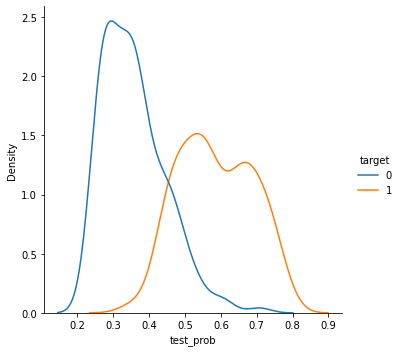

In [100]:
sns.displot(y_test,x="test_prob", hue="target",kind="kde")

## Accuracy Score

In [111]:
# Accuracy Metrics = R2, RMSE, RMSLE, MAPE
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import accuracy_score

In [112]:
accuracy_score(y_test.target, y_test.pred_class, normalize=True)

0.8566775244299675

In [118]:
# Decision Tree
# from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()

decision_tree.fit(X_train, y_train) # Train Model

y_pred = decision_tree.predict(X_test)

y_pred_prob = decision_tree.predict_proba(X_train)

In [119]:
y_pred[:5]

array([1, 0, 0, 1, 1])

## AUC Score

In [126]:
from sklearn.metrics import roc_curve,roc_auc_score,plot_roc_curve
from sklearn import metrics

In [132]:
fpr, tpr, thresholds = metrics.roc_curve(y_test.target, y_test.pred_class, pos_label=2)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [133]:
metrics.auc(fpr, tpr)

nan

# Model Building

In [137]:
# using Naive Bayes
gnb = GaussianNB()
cv_gnb = cross_val_score(gnb,X_train,y_train,cv=5)
print(cv_gnb)
print(cv_gnb.mean())

[0.60839161 0.65034965 0.63636364 0.69230769 0.62937063]
0.6433566433566433


In [138]:
print(cv_gnb)

[0.60839161 0.65034965 0.63636364 0.69230769 0.62937063]


In [139]:
# Logistic Regrission
lr = LogisticRegression(max_iter = 500)
cv_lr = cross_val_score(lr,X_train,y_train,cv=5)
print(cv_lr)
print(cv_lr.mean())

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[0.8951049  0.79020979 0.87412587 0.86013986 0.88111888]
0.8601398601398602


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [140]:
# Decision Tree
dt = tree.DecisionTreeClassifier(random_state = 1)
cv_dt = cross_val_score(dt,X_train,y_train,cv=5)
print(cv_dt)
print(cv_dt.mean())

[0.97202797 0.96503497 0.92307692 0.94405594 0.97202797]
0.9552447552447552


In [141]:
# KNN
knn = KNeighborsClassifier()
cv_knn = cross_val_score(knn,X_train,y_train,cv=5)
print(cv_knn)
print(cv_knn.mean())

[0.67132867 0.68531469 0.66433566 0.6993007  0.65734266]
0.6755244755244755


In [142]:
# Random Forest
rf = RandomForestClassifier(random_state = 1)
cv_rf = cross_val_score(rf,X_train,y_train,cv=5)
print(cv_rf)
print(cv_rf.mean())

[0.95104895 0.93706294 0.92307692 0.92307692 0.91608392]
0.93006993006993


In [145]:
# XGBoost
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state =1)
cv_xgb = cross_val_score(xgb,X_train,y_train,cv=5)
print(cv_xgb)
print(cv_xgb.mean())

[0.97902098 0.97202797 0.97202797 0.96503497 0.97902098]
0.9734265734265733


In [152]:
models = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regrission', 'Decision Tree', 
              'KNN','Random Forest',  
              'XGBoost'],
    'Score': [cv_gnb.mean(), cv_lr.mean(), cv_dt.mean(), 
              cv_knn.mean(), cv_rf.mean(),  
              cv_xgb.mean()]})
models.sort_values(by='Score', ascending=True)


,Model,Score
0,Naive Bayes,0.643357
3,KNN,0.675524
1,Logistic Regrission,0.860140
4,Random Forest,0.930070
2,Decision Tree,0.955245
5,XGBoost,0.973427


In [153]:
## Different Models and %

# Naive Bayes	- 0.64
# Logistic Regrission - 0.87
# Decision Tree - 0.95
# KNN - 0.63
# Random Forest - 0.92
# Support Vector Classifier - 0.65
# XGBoost - 0.97


# Cross Validation

## K Fold

In [154]:
from sklearn.model_selection import KFold

## Leave-P-Out cross validation

In [2]:
from sklearn.model_selection import LeavePOut
import numpy as np 

In [3]:
X = np.ones(4)
lpo = LeavePOut(p=2)
for train, test in lpo.split(X):
     print("%s %s" % (train, test))

[2 3] [0 1]
[1 3] [0 2]
[1 2] [0 3]
[0 3] [1 2]
[0 2] [1 3]
[0 1] [2 3]


## Leave-one-out cross validation

In [4]:
from sklearn.model_selection import LeaveOneOut

In [5]:
loo = LeaveOneOut()
for train, test in loo.split(X):
    print("%s %s" % (train, test))

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]


## Rolling Cross Validation